In [1]:
# TODO 
# data augmentation
# transfer learning
# learn why global average pooling is so bad?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')
# import os
# os.chdir('drive/My Drive/facial_features/code')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from random import randint

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import (Dense, Activation, SeparableConv2D, MaxPooling2D, Flatten, Dropout, 
                          BatchNormalization)
from keras.optimizers import SGD, Adam

import imgaug
from imgaug import augmenters as iaa
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage

from preprocess import load, load_coordinates_to_dataframe
from utils import plot_labelled_image, plot_labelled_sample
from model import MyModel

Using TensorFlow backend.


In [4]:
images_path = '../data/images/'
labels_path = '../data/landmarks.csv'

target_size = 80

X, y = load(images_path, labels_path)

X_norm = X / 255
y_norm = y / 80

X_train, X_test_, y_train, y_test_ = train_test_split(X_norm, y_norm, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_, y_test_, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

100%|██████████| 5999/5999 [02:45<00:00, 36.19it/s]


(4192, 80, 80, 3) (898, 80, 80, 3) (899, 80, 80, 3)


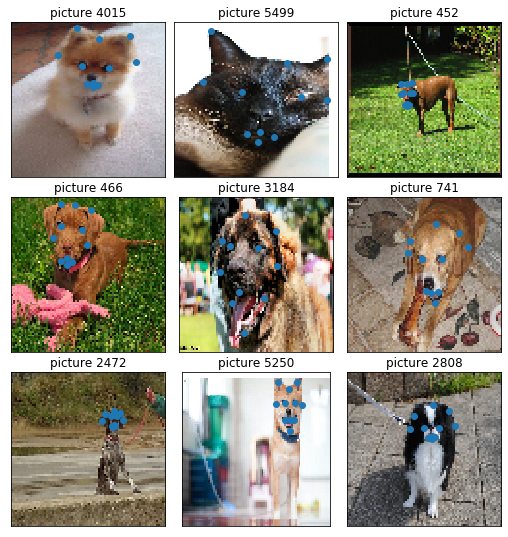

In [5]:
plot_labelled_sample(X_norm, y_norm, 80)

In [6]:
model = MyModel()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [39]:
def augment(img, kps):
    seq = iaa.Sequential([
#                                 iaa.Fliplr(0.5),
#                                 iaa.GaussianBlur((0, 3.0))
#                                 iaa.Multiply((1.2, 1.5))
                            iaa.Affine(scale=(1,2))
#                                 iaa.Affine(rotate=(-20,20))
                        ])

    keypoints = KeypointsOnImage.from_xy_array(kps, shape=img.shape)
    
    img_aug, kps_aug = seq(image=img, keypoints=keypoints)

    kps_aug = kps_aug.to_xy_array().flatten()
    
    return img_aug, kps_aug

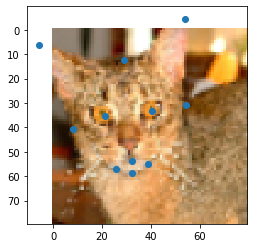

In [56]:
temp_X = X.copy()
temp_y = y.copy()

temp_im, temp_lab = augment(temp_X[2], temp_y.iloc[2].values.reshape(11,2))

temp_y.iloc[2] = temp_lab

plot_labelled_image(temp_im, temp_y.iloc[2], 80, False)

In [66]:
# TODO Images that go through augment() seem to work. Get the ones that go through generator() to work too

In [59]:
def generator(X, y, batch_size):
    
    temp_X = X.copy()
    temp_y = y.copy()
    
    batch_features = np.zeros((batch_size, target_size, target_size, 3))
    batch_labels = np.zeros((batch_size, 22)) 
    
    while True:
        for i in range(batch_size): 
            index = randint(0, temp_X.shape[0]-1)
            
            random_augmented_image, random_augmented_labels = augment(
                temp_X[index], 
                temp_y.iloc[index].values.reshape(11,2)
            )
            
            batch_features[i] = random_augmented_image
            batch_labels[i] = random_augmented_labels
                        
        yield batch_features, batch_labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 80, 80, 3)
(2, 22)


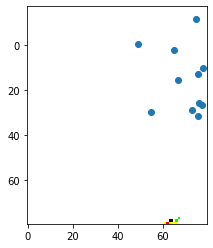

In [65]:
for a, b in generator(X, y, 2):
    print(a.shape)
    print(b.shape)
    plot_labelled_image(a[0], b[0], 80, False)
    break

In [8]:
train_generator = ImageDataGenerator()
train_generator.fit(X_train)

val_generator = ImageDataGenerator()
val_generator.fit(X_val)

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='../models/my_model.h5',
        monitor='val_loss',
        save_best_only=True,
    )
]

epochs = 50
batch_size = 64

hist = model.fit_generator(
                    generator(X_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=len(X_train)/batch_size, 
                    epochs=epochs,
                    callbacks=callbacks_list,
                    validation_data=(X_val, y_val)
                   )

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
66/65 [==============================] - 73s 1s/step - loss: 0.0614 - val_loss: 0.0564
Epoch 2/50
66/65 [==============================] - 70s 1s/step - loss: 0.0186 - val_loss: 0.0263
Epoch 3/50
66/65 [==============================] - 70s 1s/step - loss: 0.0159 - val_loss: 0.0214
Epoch 4/50
66/65 [==============================] - 71s 1s/step - loss: 0.0151 - val_loss: 0.0167
Epoch 5/50
66/65 [==============================] - 72s 1s/step - loss: 0.0145 - val_loss: 0.0146
Epoch 6/50
66/65 [==============================] - 71s 1s/step - loss: 0.0140 - val_loss: 0.0143
Epoch 7/50
66/65 [==============================] - 70s 1s/step - loss: 0.0137 - val_loss: 0.0167
Epoch 8/50
66/65 [==============================] - 69s 1s/step - loss: 0.0132 - val_loss: 0.0134
Epoch 9/50
66/65 [==============================] - 71s 1s/step - loss: 0.0126 - val_loss: 0.0160
Epoch 10/50
66/65 [==============================] - 71s 1s/step - los

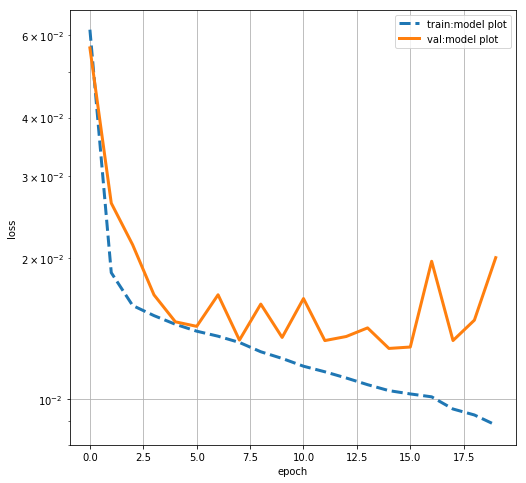

In [9]:
 def plot_loss(hist, name, plt, RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss)) * target_size/2 
        val_loss = np.sqrt(np.array(val_loss)) * target_size/2 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

plt.figure(figsize=(8,8))
plot_loss(hist, "model plot", plt)

plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [10]:
model.load_weights('../models/my_model.h5')

In [11]:
def save_model(model, name):
    json_string = model.to_json()
    open("../models/"+name+'_architecture.json', 'w').write(json_string)
    model.save_weights("../models/"+name+'_weights.h5')
    model.save("../models/"+name+'_weights_and_all.h5')

def load_model(name):
    model = model_from_json(open("../models/"+name+'_architecture.json').read())
    model.load_weights("../models/"+name + '_weights.h5')
    model.compile(loss="mean_squared_error", optimizer=Adam())
    return model

In [12]:
model = load_model("my_model")
save_model(model, "my_model")

In [91]:
model.evaluate(X_test, y_test)

899/899 [==============================] - 5s 5ms/step


1449.2316477672675

In [14]:
y_pred = model.predict(X_test)

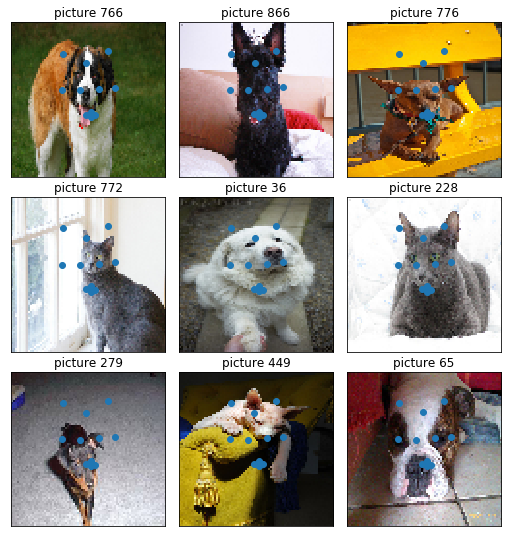

In [15]:
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,left=0,right=1,bottom=0, top=1)
Npicture = 9
count = 1
for irow in range(Npicture):
    ipic = np.random.choice(X_test.shape[0])
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_example(X_test[ipic], y_pred[ipic], ax)
    ax.set_title("picture "+ str(ipic))
    count += 1
plt.show()

In [ ]:
# Weight decay in layers
######################################################################
# from keras import regularizers

# model = models.Sequential()
# model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(10000,)))
# model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

# Callbacks like learning rate scheduling
######################################################################

# Tensorboard
######################################################################

# Pretrained Xception weights
######################################################################